# Figures for paper

Sam Maurer, Nov 2018

Launch the mongodb server first:  
`mongod --dbpath ~/mongodb-data`

https://api.mongodb.com/python/current/api/pymongo/index.html  
https://docs.mongodb.com/manual/reference/operator/aggregation-pipeline/

In [1]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymongo

import datetime
import os

In [2]:
print(np.__version__)
print(pd.__version__)
print(matplotlib.__version__)
print(pymongo.__version__)

1.15.2
0.23.4
2.2.3
3.7.1


### Mongodb connection

In [3]:
client = pymongo.MongoClient()
print(client.server_info()['version'])

4.0.3


In [4]:
db = client.tweets
col = db.westcoastmonthly
r1 = db.westcoast_monthly_random_10k
r2 = db.westcoast_monthly_random_1M

In [5]:
print(col.estimated_document_count())

18000000


### Figure: rate of posts by month

In [6]:
%%time

n_tweets = 500000
ms_to_hrs = 1000*60*60

c1 = list(col.aggregate([
    {"$addFields": {"_dt": {"$toDate": {"$toLong": "$timestamp_ms"}}}}, 
    {"$group": {"_id": {"y": {"$year": "$_dt"}, "m": {"$month": "$_dt"}}, 
                "maxTimestamp": {"$max": "$_dt"},
                "minTimestamp": {"$min": "$_dt"}}},
    {"$addFields": {"value": {"$divide": [n_tweets * ms_to_hrs, 
                        {"$subtract": ["$maxTimestamp", "$minTimestamp"]}]}}}]))

CPU times: user 57.1 ms, sys: 17.3 ms, total: 74.4 ms
Wall time: 4min 49s


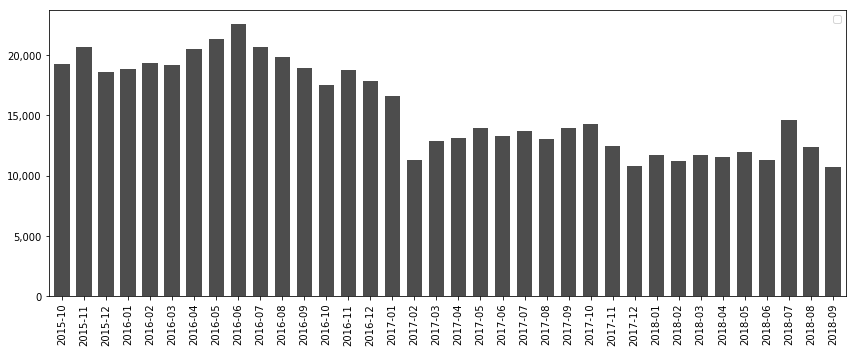

In [7]:
ym, value = ([], [])

for doc in c1:
    if doc['_id']['y'] is not None:
        ym.append(str(doc['_id']['y']) + '-' + str(doc['_id']['m']).zfill(2))
        value.append(doc['value'])

df = pd.DataFrame({'ym': ym, 'value': value}).sort_values('ym')

fig, ax = plt.subplots(figsize=(12,5))
df.plot.bar(x='ym', y='value', width=0.7, ax=ax, facecolor=(0.3,0.3,0.3))

#plt.title('Place-tagged Twitter posts per hour in study area')
ax.legend('')
ax.set_xlabel('')

ax.get_yaxis().set_major_formatter(
    matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))

plt.tight_layout()
plt.show()

In [8]:
fig.savefig('output/fig-post-volume.pdf')

### Figure: GPS tag quality

In [9]:
def to_lists(c):
    ym, value = ([], [])
    for doc in c:
        if doc['_id']['y'] is not None:
            ym.append(str(doc['_id']['y']) + '-' + str(doc['_id']['m']).zfill(2))
            value.append(doc['value'])
    return ym, value

In [10]:
def match(d):
    c = list(col.aggregate([
    {"$match": d},
    {"$addFields": {"_dt": {"$toDate": {"$toLong": "$timestamp_ms"}}}}, 
    {"$group": {"_id": {"y": {"$year": "$_dt"}, "m": {"$month": "$_dt"}}, 
                "value": {"$sum": 1}}}]))
    return c

In [11]:
%%time
c = match({"geo": {"$ne": None}})
ym, value = to_lists(c)
df1 = pd.DataFrame({'ym': ym, 'all': value}).sort_values('ym').set_index('ym')

CPU times: user 44.6 ms, sys: 20.5 ms, total: 65.1 ms
Wall time: 3min 18s


In [12]:
%%time
c = match({"$and": [{"geo": {"$ne": None}}, {"source": {"$regex" : ".*>Twitter .*"}}]})
ym, value = to_lists(c)
df2 = pd.DataFrame({'ym': ym, 'twitter': value}).sort_values('ym').set_index('ym')

CPU times: user 51.9 ms, sys: 16.4 ms, total: 68.2 ms
Wall time: 3min 58s


In [13]:
%%time
c = match({"$and": [{"geo": {"$ne": None}}, {"source": {"$regex" : ".*>Instagram<.*"}}]})
ym, value = to_lists(c)
df3 = pd.DataFrame({'ym': ym, 'instagram': value}).sort_values('ym').set_index('ym')

CPU times: user 54.6 ms, sys: 23.3 ms, total: 77.9 ms
Wall time: 4min 7s


In [14]:
%%time
c = match({"$and": [{"geo": {"$ne": None}}, {"source": {"$regex" : ".*>Foursquare<.*"}}]})
ym, value = to_lists(c)
df4 = pd.DataFrame({'ym': ym, 'foursquare': value}).sort_values('ym').set_index('ym')

CPU times: user 51.8 ms, sys: 17.4 ms, total: 69.1 ms
Wall time: 4min 3s


In [15]:
df = df1.join([df2, df3, df4])
df['instasquare'] = df.instagram + df.foursquare
df['other'] = df['all'] - (df.twitter + df.instagram + df.foursquare)
print(df)

            all  twitter  instagram  foursquare  instasquare    other
ym                                                                   
2015-10   65119     8649    31708.0        5149      36857.0  19613.0
2015-11   64762     7168    25458.0        3602      29060.0  28534.0
2015-12   58158     5372    20940.0        3293      24233.0  28553.0
2016-01   66202     4430    29725.0        5063      34788.0  26984.0
2016-02   59372     4743    22713.0        3408      26121.0  28508.0
2016-03   62292     3297    23997.0        3815      27812.0  31183.0
2016-04   70516     2836    36051.0        5200      41251.0  26429.0
2016-05   64368     2362    31776.0        4108      35884.0  26122.0
2016-06   53827     1822    23275.0        2932      26207.0  25798.0
2016-07   66891     1814    34871.0        4863      39734.0  25343.0
2016-08   51408     1066    24440.0        3268      27708.0  22634.0
2016-09   62995     1396    30235.0        4383      34618.0  26981.0
2016-10   78244     

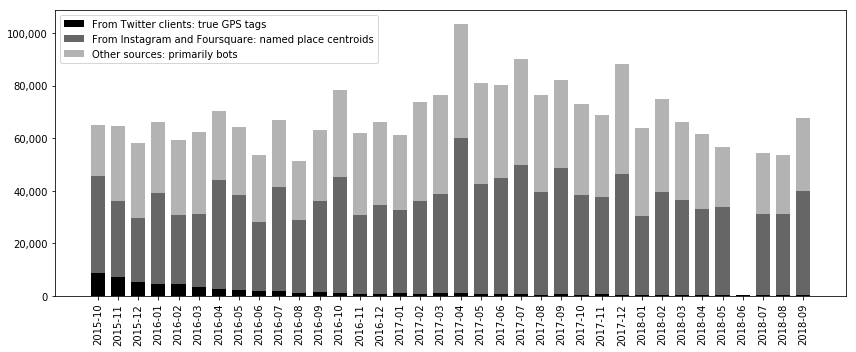

In [16]:
fig, ax = plt.subplots(figsize=(12,5))
width = 0.7

p1 = plt.bar(df.index, df.twitter, width, color=(0,0,0))
p2 = plt.bar(df.index, df.instasquare, width, bottom=df.twitter, color=(0.4,0.4,0.4))
p3 = plt.bar(df.index, df.other, width, bottom=df.twitter+df.instasquare, color=(0.7,0.7,0.7))

#df.plot.bar(x='ym', y='value', ax=ax, facecolor='black')

#plt.title('Twitter posts ostensibly tagged with GPS coordinates')
ax.legend('')
ax.set_xlabel('')
plt.xticks(rotation='vertical')

ax.get_yaxis().set_major_formatter(
    matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))

ax.legend((p1[0], p2[0], p3[0]), 
          ('From Twitter clients: true GPS tags', 
           'From Instagram and Foursquare: named place centroids',
           'Other sources: primarily bots'))

plt.tight_layout()
plt.show()

In [17]:
fig.savefig('output/fig-gps-tags.pdf')